In [ ]:
#this is just going to be a clone of unit 2 multi, but now after taking a big break, just making sure i still got it frfr

'''
What are we doin:
we will make a dataset using sklearn.datasets.make_blobs or something
first, try to input that into a dataframe, where the columns are x, y, and the class respectively
next, try to plot the data, with a custom legend that maps the color to the index class (tricky)
next, we need to turn the data into tensors, specifically into Dataset and Dataloader objects on the CPU.
(THIS WILL BE NEW)

Next, lets define the model, since this data is simple, just make a MLP with Relu, and it should suffice

First, do a deadshot on the model, and plot the prediction boundary (tests teh download from the github)

Next, the training. Do a check on the time it takes to run, using tqdm for the training loop, and timeit to compare cpu and gpu

(REMEMBER TO WRITE THE TRAIN AND TEST EPOCH FUNCTIONS TO MINIMIZE BLOCKY CODE)

(REMEMBER IN THE TRAIN/TEST LOOP TO USE THE CSV AND PATHFILE TO WRITE EVERY EPOCH INTO THE CSV FILE)
(REMEMBER TO USE THE ACCURACY OBJECTS, AND JUST AFTER EACH TRAIN_BATCH AND TEST_BATCH JUST RETURN THE LOSS, ACC, 
(REMEMBER TO PRINT WHICH BATCH WE ARE AT EVERY FEW BATCHES)

(REMEMBER OT WRITE A SAVE_STATE)

ALSO, WRITE AN EVALUATE MODEL TO RUN AT THE END OF THE TRAINING, WHICH TAKES THE MODEL, DATA_LOADER, LOSS_FN


we will use CrossEntropyLoss, which is a loss function for multiple datasets that works on logits (it automatically converts to 
prediction probabilities using softmax, which makes all the elements in the tensor dim sum to 1)

the loss is the sum of the prediction probability times which is the correct class.
CrossEntropyLoss = SUM -1 * ( qi * log(pi))
where q1 is 1 if the class is the desired class, else 0, and if pi is small then the value of log(pi) is large negative so the loss
is huge, while if it is close to 1 the log is close to 0 and thus the loss is near 0.




'''

In [7]:
#imports
import torch
from torch import nn #inside of nn, there is nn.Module, which is the overall class which all things like 
#nn.sequential or nn.ReLU inherit from. also torch.nn holds the loss functions, which these are also nn.Modules.
import matplotlib.pyplot as plt
import pandas as pd #i think i need to practice using pandas, like how you can use pd.save_csv() to save a data
from sklearn.datasets import make_blobs
import numpy as np



In [ ]:
#lets get this party started:

#device agnostic code:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"device = {device}")

#we not gotta do allat with the cpu vs gpu and the timeit, lets just make one timeit function to see how long it took to train

#now, lets make the dataset:
num_samples = 1000
num_features = 2 #the number of features, we want 2d data so 2 is fine
centers = 5 #number of classes
cluster_std = 1

X,Y = make_blobs(n_samples=num_samples,n_features=num_features,centers=centers,cluster_std=cluster_std,shuffle=True)
X.dtype,Y.dtype #same as torch tensors, but are ndarrays of type float64 and int64, both not good and not in tensor form, but fine for now
X[:10],Y[:10] #returns the first 10 elements of the stuff

#QUICK DETOUR TO DISCUSS ARRAY INDEXING IN PYTHON!!!
# arr[index] gives element at index
#arr[-index] gives element from the back, or -1 means the last element, -2 is second last, etc..
#slicing:
# format arr[start:end:stop]
#START IS INCLUSIVE, STOP IS EXCLUSIVE
#NOTE, the start/stop defaults change depending on the value of step
#for positive steps, start is 0, and stop is len(arr)
#for negative steps, start is len(arr) - 1 , last index, and the stop is -1

#In pytorch, slicing is the same, only using commas to separate dimensions, starting at dim = 0.

#NOW: lets practice some dataframes, then lets practice using the torch.tensor manipulation functions from unit 0!


device = mps


(array([[ 1.12252571, -6.75044428],
        [ 3.73796467, -3.49083054],
        [-1.19073413, -7.55440267],
        [ 6.62378743, -2.72777826],
        [ 1.74164442, -9.19738954],
        [-1.43899736, -2.65395328],
        [ 7.50497273,  7.51746442],
        [ 0.43832665, -7.87113533],
        [ 6.44003568,  6.32225326],
        [-0.19253636, -7.18139699]]),
 array([2, 2, 0, 3, 0, 4, 1, 0, 1, 0]))

In [ ]:
#we got the X and Y ndarrays, lets try to put them into a dataframe, and just use the 64 bit defaults that are returned



In [23]:
#now, lets take the data and put in into a pandas dataframe
#slices need ints or None, cannot have calculation, just do them ahead of time:

train_data_dict = {
    'X': X[:int(len(X)*0.8),0],
    'Y': X[:int(len(X)*0.8),1],
    'Label': Y[:int(len(X)*0.8)]
}

test_data_dict ={
    "X": X[int(len(X)*0.8):,0],
    "Y": X[int(len(X)*0.8):,1],
    "Label": Y[int(len(X)*0.8):]
}

trainDF = pd.DataFrame(data=train_data_dict)
testDF = pd.DataFrame(data=test_data_dict)
trainDF.head(10),testDF.head(10), len(trainDF),len(testDF)



(           X         Y  Label
 0   2.129285  8.159293      3
 1   8.147657  4.180786      1
 2   1.921159  9.353000      3
 3   0.532909  6.621954      3
 4   8.114305  4.244339      1
 5  -2.045554 -6.250155      4
 6   1.229905  8.610502      3
 7   1.598280 -0.354144      0
 8   0.017123 -0.648398      0
 9  10.913440 -6.142952      2,
           X         Y  Label
 0  0.789764  8.785457      3
 1  7.584468  6.749117      1
 2  8.417622  5.756928      1
 3  9.727899 -5.305815      2
 4  0.582175  2.588846      0
 5  8.910634  6.292043      1
 6  5.707453 -3.126577      2
 7  2.763379  0.621437      0
 8 -4.399195 -5.339484      4
 9  9.836845 -5.254099      2,
 800,
 200)

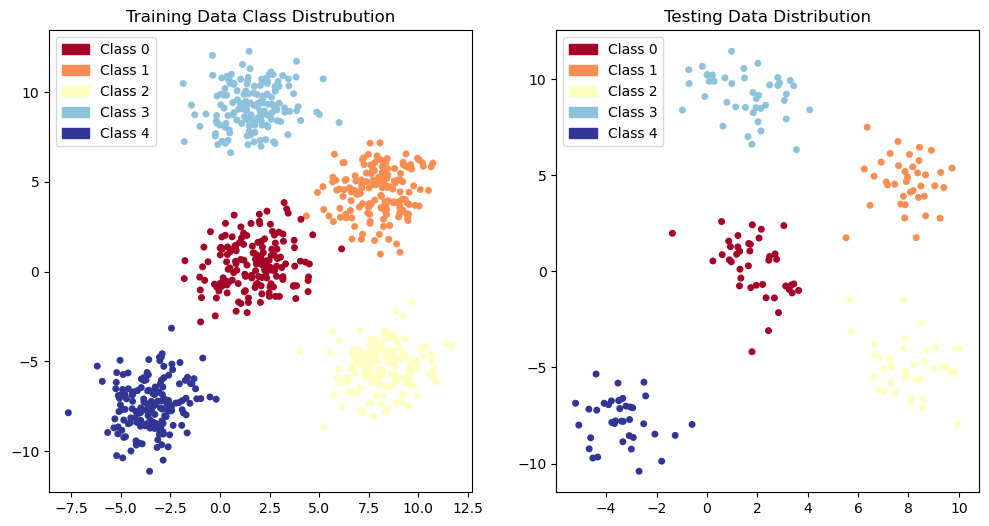

In [ ]:
#now, lets plot the data using the dataframe and matplotlib, remember the custom labels in the legend
from matplotlib.patches import Patch
import numpy as np

#note, i remember there was also something special with how cmap worked, in that it only accepted data from 0 to 1 or something
#if its min, then make it 0, if its max then make it 1
#so you ahve to normalize with. (value - min) / (max - min) or something

#first, lets split it into training and testing dataframes, no

#now for the handle, i believe we also need to use the torch.unique() and also use a for loop to create a patch for each color


#lets think abt this: each class will have an index in the label, which is mapped betwene 0 and 1 for the cmap, thus, 
unique_arr = np.unique(trainDF["Label"].to_numpy())

plot_handles = [
    Patch(color=plt.cm.RdYlBu((color - unique_arr.min()) / (unique_arr.max() - unique_arr.min())),label=f"Class {color}")
    for color in unique_arr #this will set color to 1, 2, ... 5 all the classes
]

#NOTE: ERRLOG!!! a set in python is unordered, so when you pass a set, it comes out in a random order
#THE ORDER OF THE ITERATION DEPENDS ON THE INTERNAL HASH FOR A SET, WHEREAS FOR A LIST IT IS IN THE ORDER OF DEFINITION


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(trainDF["X"],trainDF["Y"],s=16,c=trainDF["Label"],cmap=plt.cm.RdYlBu,label="Train Data")
plt.title("Training Data Class Distrubution")
plt.axis(None)
plt.legend(handles = plot_handles)

plt.subplot(1,2,2)
plt.scatter(testDF["X"],testDF["Y"],s=16,c=testDF["Label"],cmap=plt.cm.RdYlBu,label="Test Data")
plt.title("Testing Data Distribution")
plt.axis(None)
plt.legend(handles = plot_handles)



In [ ]:
#you know what would be super SIGMA, if you were to save the dataframe as a csv and then impliment the Dataset object
#like you would normally, with the imgpath, transform, annotations_file, and target transform (you will have to do this bc it 
# might not work by default. First, lets take our training and testing dataframes and save them into a file called data_rem
#with two constituent files. now, to make it sharable, can we save them as a csv and then compress them using torch.save pickle files

In [ ]:
#now that we plotted our data, lets shove it into a dataset and a dataloader:
#lowkey idk how to do this tho...
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

#NOTE:dataset is an abstract class, BUT DATALOADER IS NOT, GENERALLY YOU WILL NOT CHANGE THE DATALOADER BUT WILL CHANGE THE DATASET
class Binary_Class_Dataset(Dataset):
    def __init__(self):
        super().__init__()
    def __getitem__(self, index):
        return super().__getitem__(index)
